<a href="https://colab.research.google.com/github/jjg5fg/Deep-Leaning-Project/blob/main/Bert_Tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
#from wordcloud import WordCloud

#Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [33]:
!pip install contractions

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [35]:
from google.colab import files
uploaded = files.upload()

Saving tweet_emotions.csv to tweet_emotions (1).csv


In [37]:
df = pd.read_csv('tweet_emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [38]:
df.shape

(40000, 3)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [40]:
df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [41]:
df.duplicated().sum()

0

In [42]:
df.drop('tweet_id', axis=1, inplace=True)

In [43]:
df['sentiment'].value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

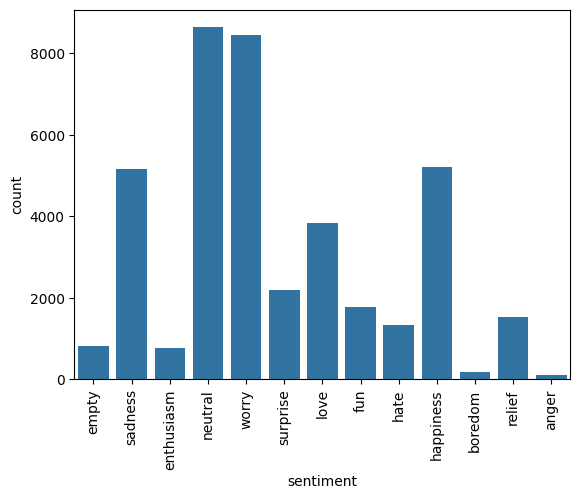

In [44]:
sns.countplot(x=df['sentiment'])
plt.xticks(rotation=90)
plt.show()

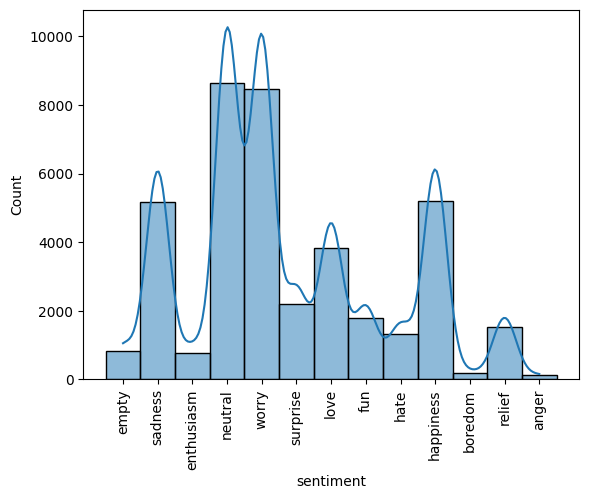

In [45]:
sns.histplot(x=df['sentiment'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [46]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [47]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Remove junk

In [48]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):

    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text

    ## Next step is text-normalization

    # Text normalization includes many steps.

    # Each function below serves a step.


    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words


    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words


    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words


    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words


    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words


    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems


    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas


    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words

    # All above functions work on word tokens we need a tokenizer

    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)


    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text

    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]


    # return processed df
    return df

In [49]:
df = text_preprocessing_platform(df, 'content', remove_stopwords=True)

In [51]:
df.head()

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin n bed headache ughhhh waitin call
2,sadness,funeral ceremony gloomy friday
3,enthusiasm,want hang friends soon
4,neutral,dannycastillo want trade someone houston ticke...


In [52]:
df['sentiment'].value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

In [19]:
def categorize_sentiment(row):
    if row['sentiment'] in ['empty', 'sadness', 'anger', 'worry', 'hate', 'boredom']:
        return 'Concerned'
    elif row['sentiment'] in ['neutral','relief','surprise','enthusiasm', 'happiness', 'love', 'fun']:  # Note: 'empty' appears again; check if this is correct.
        return 'Neutral'
    #elif row['sentiment'] in ['enthusiasm', 'happiness', 'love', 'fun']:
    #    return 'Positive'
    #elif row['sentiment'] in ['neutral']:
       # return 'Neutral'
    else:
        return 'Undefined'  # Handle any cases that don't fit the above categories

# Apply the function along the rows of the DataFrame
df['category'] = df.apply(categorize_sentiment, axis=1)

In [21]:
#df.rename(columns={'sentiment': 'category'}, inplace=True)

In [22]:
df

,sentiment,content,category
0,empty,tiffanylue know listenin bad habit earlier sta...,Concerned
1,sadness,layin n bed headache ughhhh waitin call,Concerned
2,sadness,funeral ceremony gloomy friday,Concerned
3,enthusiasm,want hang friends soon,Neutral
4,neutral,dannycastillo want trade someone houston ticke...,Neutral
...,...,...,...
39995,neutral,johnlloydtaylor,Neutral
39996,love,happy mother day love,Neutral
39997,love,happy mother day mommies woman man long momma ...,Neutral
39998,happiness,niariley wassup beautiful follow peep new hit ...,Neutral


# Balance data

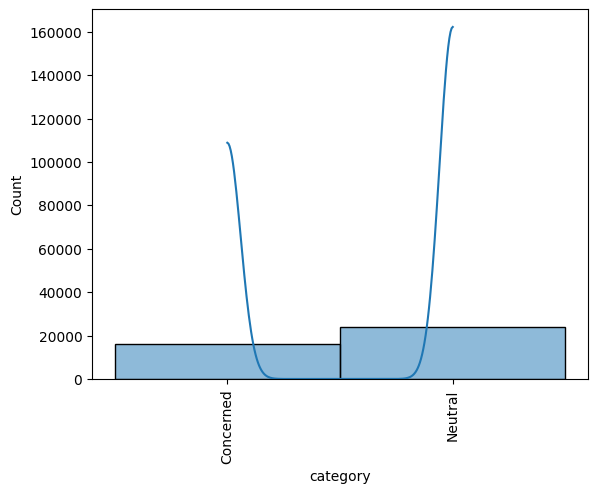

In [23]:
sns.histplot(x=df['category'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [24]:
df['category'].value_counts()

category
Neutral      23937
Concerned    16063
Name: count, dtype: int64

In [25]:
df

,sentiment,content,category
0,empty,tiffanylue know listenin bad habit earlier sta...,Concerned
1,sadness,layin n bed headache ughhhh waitin call,Concerned
2,sadness,funeral ceremony gloomy friday,Concerned
3,enthusiasm,want hang friends soon,Neutral
4,neutral,dannycastillo want trade someone houston ticke...,Neutral
...,...,...,...
39995,neutral,johnlloydtaylor,Neutral
39996,love,happy mother day love,Neutral
39997,love,happy mother day mommies woman man long momma ...,Neutral
39998,happiness,niariley wassup beautiful follow peep new hit ...,Neutral


In [26]:
label_mapping = {'Neutral': 0, 'Concerned': 1}#, 'Concerned':2}, 'happiness': 2, 'sadness':3, 'love':4, 'surprise':5,'fun':6, 'relief':7, 'hate':8, 'empty':9,
              #  'enthusiasm':10, 'boredom':11,'anger':12}
df['category'] = df['category'].map(label_mapping)


In [27]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 28000; Test: 12000


In [28]:
train_df

,sentiment,content,category
38015,sadness,ficklampa hehe option advertise world mess mig...,1
2281,boredom,wake day need go work suck also go dentist fil...,1
36629,neutral,ilhongy would get,0
6087,worry,penbleth leave forever miss much,1
11792,neutral,lt train today ehhh hard tall hard feel good s...,0
...,...,...,...
6265,neutral,clean,0
11284,hate,ooo goddddd vodafone trouble network,1
38158,fun,watch run fat boy run haha soo funny,0
860,hate,calvinharris make pork products fuck stop impo...,1


In [29]:
X_train = train_df['content'].values
y_train = train_df['category'].values

X = test_df['content'].values
y = test_df['category'].values

test_df, val_df = train_test_split(test_df, test_size=0.25)

X_valid = val_df['content'].values
y_valid = val_df['sentiment'].values

X_test = test_df['content'].values
y_test = test_df['sentiment'].values

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 28000; X_test: 9000; X_valid: 3000
y_train: 28000; y_test: 9000; y_valid: 3000


In [31]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [32]:
labels = df['category'].unique()


In [33]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased",
                                                           num_labels=len(labels))

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
is_train=True

In [62]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm


In [36]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])
val_df['category'] = label_encoder.transform(val_df['category'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['category'].values)
y_test = torch.tensor(test_df['category'].values)
y_valid = torch.tensor(val_df['category'].values)

In [37]:

from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64)
val_dataset = TensorDataset(X_valid, y_valid)
val_dataloader = DataLoader(val_dataset, batch_size=64)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Attention mask added by default
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [39]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss
training_loss = []
validation_loss = []
for epoch in range(10):  # Run for 10 epochs
    train_loss = train(model, train_dataloader, optimizer, criterion)
    training_loss.append(train_loss)
    val_loss = validate(model, val_dataloader, criterion,device)
    validation_loss.append(val_loss)
    print(f"Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}")
# Evaluate on test and validation sets
test_cm, test_report = evaluate(model, test_dataloader)
print("Test Set Evaluation:")
print("Confusion Matrix:")
print(test_cm)
print("Classification Report:")
print(test_report)

valid_cm, valid_report = evaluate(model, val_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

Validation: 100%|██████████| 47/47 [00:02<00:00, 16.16it/s]


Epoch 1/10, Train Loss: 0.5189


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.14it/s]


Epoch 2/10, Train Loss: 0.4837


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.16it/s]


Epoch 3/10, Train Loss: 0.4325


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.13it/s]


Epoch 4/10, Train Loss: 0.3672


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.08it/s]


Epoch 5/10, Train Loss: 0.2917


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.18it/s]


Epoch 6/10, Train Loss: 0.2272


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.20it/s]


Epoch 7/10, Train Loss: 0.1708


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.12it/s]


Epoch 8/10, Train Loss: 0.1389


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.10it/s]


Epoch 9/10, Train Loss: 0.1045


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.15it/s]


Epoch 10/10, Train Loss: 0.0875
Test Set Evaluation:
Confusion Matrix:
[[3948 1512]
 [1331 2209]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.75      0.72      0.74      5460
   Concerned       0.59      0.62      0.61      3540

    accuracy                           0.68      9000
   macro avg       0.67      0.67      0.67      9000
weighted avg       0.69      0.68      0.69      9000

Validation Set Evaluation:
Confusion Matrix:
[[1277  487]
 [ 454  782]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.74      0.72      0.73      1764
   Concerned       0.62      0.63      0.62      1236

    accuracy                           0.69      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.69      0.69      0.69      3000



In [67]:
def plot_loss_over_epochs(train_losses, val_losses):

    if len(train_losses) != len(val_losses):
        raise ValueError("train_losses and val_losses must be of the same length.")

    epochs = list(range(1, len(train_losses) + 1))

    # Create DataFrame to organize the data
    model_loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Average Training Loss': train_losses,
        'Validation Loss': val_losses
    })

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(model_loss_df['Epoch'], model_loss_df['Average Training Loss'], label='Average Training Loss', marker='o')
    plt.plot(model_loss_df['Epoch'], model_loss_df['Validation Loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

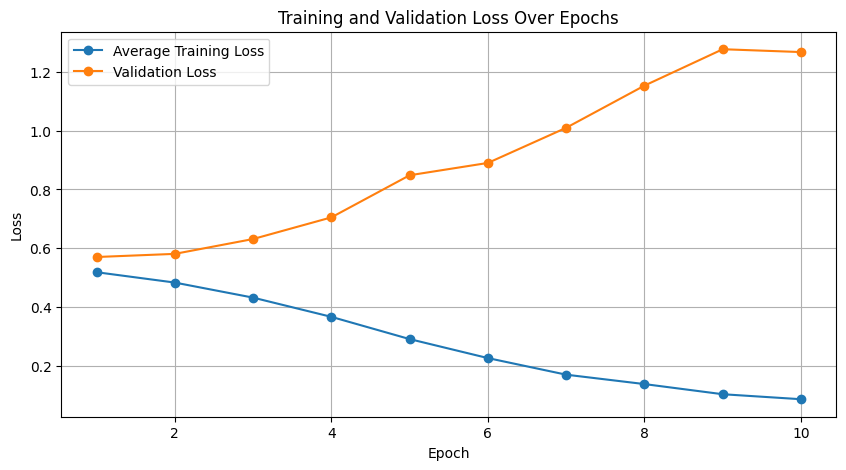

In [40]:


plot_loss_over_epochs(training_loss, validation_loss)

In [54]:
def categorize_sentiment(row):
    if row['sentiment'] in ['empty', 'sadness', 'anger', 'worry', 'hate', 'boredom']:
        return 'Concerned'
    elif row['sentiment'] in ['neutral']:  # Note: 'empty' appears again; check if this is correct.
        return 'Neutral'
    elif row['sentiment'] in ['enthusiasm', 'happiness', 'love', 'fun','relief','surprise']:
        return 'Positive'
    #elif row['sentiment'] in ['neutral']:
       # return 'Neutral'
    else:
        return 'Undefined'  # Handle any cases that don't fit the above categories

# Apply the function along the rows of the DataFrame
df['category'] = df.apply(categorize_sentiment, axis=1)


In [42]:
df

,sentiment,content,category
0,empty,tiffanylue know listenin bad habit earlier sta...,Concerned
1,sadness,layin n bed headache ughhhh waitin call,Concerned
2,sadness,funeral ceremony gloomy friday,Concerned
3,enthusiasm,want hang friends soon,Positive
4,neutral,dannycastillo want trade someone houston ticke...,Neutral
...,...,...,...
39995,neutral,johnlloydtaylor,Neutral
39996,love,happy mother day love,Positive
39997,love,happy mother day mommies woman man long momma ...,Positive
39998,happiness,niariley wassup beautiful follow peep new hit ...,Positive


In [55]:
label_mapping = {'Neutral': 0, 'Concerned': 1, 'Positive':2}# 'happiness': 2, 'sadness':3, 'love':4, 'surprise':5,'fun':6, 'relief':7, 'hate':8, 'empty':9,
              #  'enthusiasm':10, 'boredom':11,'anger':12}
df['category'] = df['category'].map(label_mapping)

In [56]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 28000; Test: 12000


In [57]:
X = test_df['content'].values
y = test_df['category'].values

test_df, val_df = train_test_split(test_df, test_size=0.25)

X_valid = val_df['content'].values
y_valid = val_df['sentiment'].values
X_train = train_df['content'].values
y_train = train_df['sentiment'].values
X_test = test_df['content'].values
y_test = test_df['sentiment'].values

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 28000; X_test: 9000; X_valid: 3000
y_train: 28000; y_test: 9000; y_valid: 3000


In [58]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [59]:
labels = df['category'].unique()

In [60]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased",
                                                           num_labels=len(labels))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
is_train=True

In [63]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])
val_df['category'] = label_encoder.transform(val_df['category'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['category'].values)
y_test = torch.tensor(test_df['category'].values)
y_valid = torch.tensor(val_df['category'].values)

In [64]:
from transformers import AutoTokenizer
import numpy as np
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased",
                                                           num_labels=len(labels))

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64)
val_dataset = TensorDataset(X_valid, y_valid)
val_dataloader = DataLoader(val_dataset, batch_size=64)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Attention mask added by default
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [65]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    return cm, report

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [53]:

training_loss = []
validation_loss = []

for epoch in range(10):  # Run for 10 epochs
    train_loss = train(model, train_dataloader, optimizer, criterion)
    training_loss.append(train_loss)
    val_loss = validate(model, val_dataloader, criterion,device)
    validation_loss.append(val_loss)
    print(f"Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}")
# Evaluate on test and validation sets
test_cm, test_report = evaluate(model, test_dataloader)
print("Test Set Evaluation:")
print("Confusion Matrix:")
print(test_cm)
print("Classification Report:")
print(test_report)

valid_cm, valid_report = evaluate(model, val_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

Validation: 100%|██████████| 47/47 [00:02<00:00, 16.16it/s]


Epoch 1/10, Train Loss: 0.9500


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.12it/s]


Epoch 2/10, Train Loss: 0.8485


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.14it/s]


Epoch 3/10, Train Loss: 0.8040


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.15it/s]


Epoch 4/10, Train Loss: 0.7454


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.14it/s]


Epoch 5/10, Train Loss: 0.6657


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.14it/s]


Epoch 6/10, Train Loss: 0.5724


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.18it/s]


Epoch 7/10, Train Loss: 0.4744


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.17it/s]


Epoch 8/10, Train Loss: 0.3846


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.19it/s]


Epoch 9/10, Train Loss: 0.3051


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.17it/s]


Epoch 10/10, Train Loss: 0.2477
Test Set Evaluation:
Confusion Matrix:
[[ 624  675  658]
 [ 491 2286  796]
 [ 491  793 2186]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.39      0.32      0.35      1957
   Concerned       0.61      0.64      0.62      3573
    Positive       0.60      0.63      0.61      3470

    accuracy                           0.57      9000
   macro avg       0.53      0.53      0.53      9000
weighted avg       0.56      0.57      0.56      9000

Validation Set Evaluation:
Confusion Matrix:
[[207 247 209]
 [162 773 268]
 [142 283 709]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.41      0.31      0.35       663
   Concerned       0.59      0.64      0.62      1203
    Positive       0.60      0.63      0.61      1134

    accuracy                           0.56      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.55      0

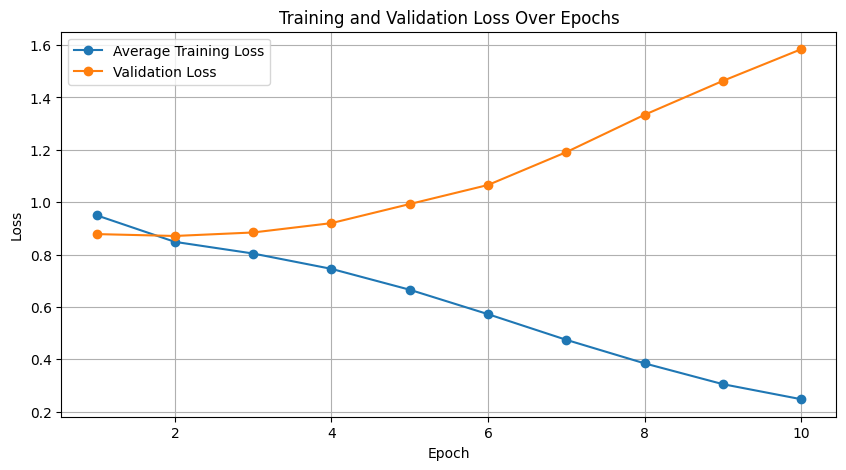

In [54]:
plot_loss_over_epochs(training_loss, validation_loss)

Batch Size: 32, Learning Rate: 0.0001


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 94/94 [00:03<00:00, 31.00it/s]


Epoch 1/10, Train Loss: 1.0760


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.97it/s]


Epoch 2/10, Train Loss: 1.0718


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.91it/s]


Epoch 3/10, Train Loss: 1.0694


Validation: 100%|██████████| 94/94 [00:03<00:00, 31.00it/s]


Epoch 4/10, Train Loss: 1.0685


Validation: 100%|██████████| 94/94 [00:03<00:00, 31.07it/s]


Epoch 5/10, Train Loss: 1.0676


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.91it/s]


Epoch 6/10, Train Loss: 1.0675


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.99it/s]


Epoch 7/10, Train Loss: 1.0665


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.93it/s]


Epoch 8/10, Train Loss: 1.0670


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.99it/s]


Epoch 9/10, Train Loss: 1.0667


Validation: 100%|██████████| 94/94 [00:03<00:00, 31.03it/s]


Epoch 10/10, Train Loss: 1.0666
Test Set Evaluation:
Confusion Matrix:
[[   0    0 1972]
 [   0    0 3557]
 [   0    0 3471]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00      1972
   Concerned       0.00      0.00      0.00      3557
    Positive       0.39      1.00      0.56      3471

    accuracy                           0.39      9000
   macro avg       0.13      0.33      0.19      9000
weighted avg       0.15      0.39      0.21      9000

Validation Set Evaluation:
Confusion Matrix:
[[   0    0  648]
 [   0    0 1219]
 [   0    0 1133]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       648
   Concerned       0.00      0.00      0.00      1219
    Positive       0.38      1.00      0.55      1133

    accuracy                           0.38      3000
   macro avg       0.13      0.33      0.18      3000
weighted avg       0.

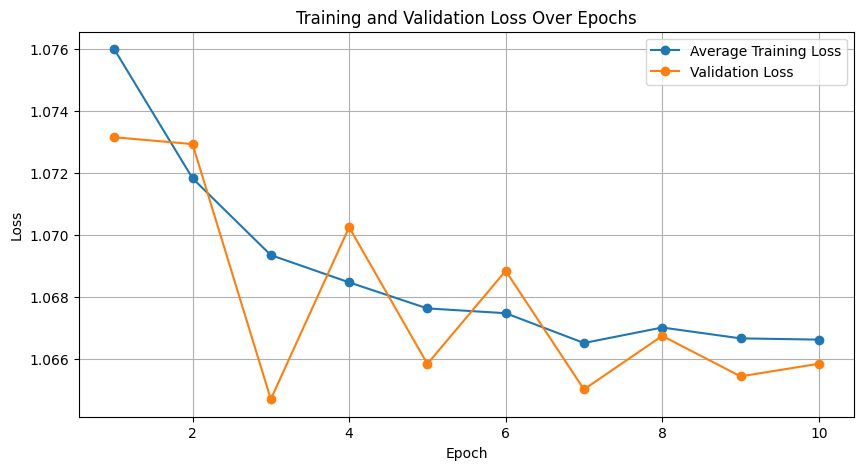

Batch Size: 32, Learning Rate: 1e-06


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 94/94 [00:03<00:00, 30.81it/s]


Epoch 1/10, Train Loss: 1.0577


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.76it/s]


Epoch 2/10, Train Loss: 0.9886


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.75it/s]


Epoch 3/10, Train Loss: 0.9249


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.71it/s]


Epoch 4/10, Train Loss: 0.8937


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.61it/s]


Epoch 5/10, Train Loss: 0.8800


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.67it/s]


Epoch 6/10, Train Loss: 0.8670


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.69it/s]


Epoch 7/10, Train Loss: 0.8610


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.69it/s]


Epoch 8/10, Train Loss: 0.8495


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.70it/s]


Epoch 9/10, Train Loss: 0.8423


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.67it/s]


Epoch 10/10, Train Loss: 0.8336
Test Set Evaluation:
Confusion Matrix:
[[ 509  666  797]
 [ 299 2367  891]
 [ 227  687 2557]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.49      0.26      0.34      1972
   Concerned       0.64      0.67      0.65      3557
    Positive       0.60      0.74      0.66      3471

    accuracy                           0.60      9000
   macro avg       0.58      0.55      0.55      9000
weighted avg       0.59      0.60      0.59      9000

Validation Set Evaluation:
Confusion Matrix:
[[168 214 266]
 [ 98 809 312]
 [ 67 225 841]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.50      0.26      0.34       648
   Concerned       0.65      0.66      0.66      1219
    Positive       0.59      0.74      0.66      1133

    accuracy                           0.61      3000
   macro avg       0.58      0.56      0.55      3000
weighted avg       0.60      0

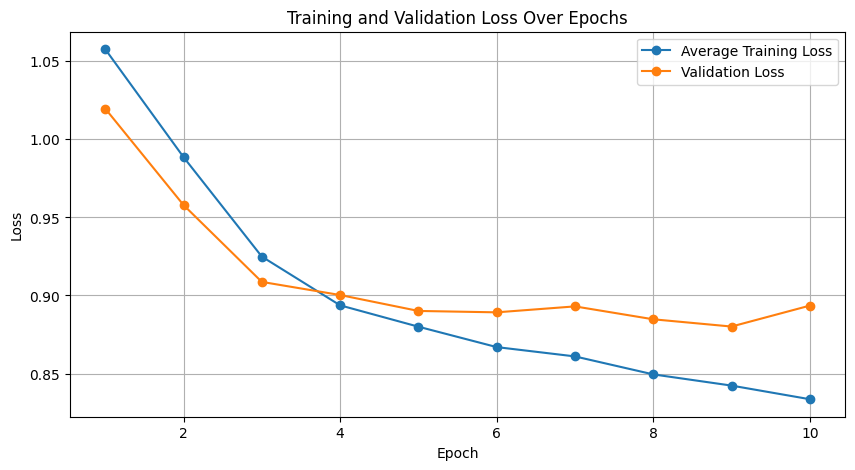

Batch Size: 32, Learning Rate: 1e-08


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 94/94 [00:03<00:00, 30.71it/s]


Epoch 1/10, Train Loss: 1.1047


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.79it/s]


Epoch 2/10, Train Loss: 1.0895


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.74it/s]


Epoch 3/10, Train Loss: 1.0796


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.67it/s]


Epoch 4/10, Train Loss: 1.0740


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.75it/s]


Epoch 5/10, Train Loss: 1.0705


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.79it/s]


Epoch 6/10, Train Loss: 1.0675


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.73it/s]


Epoch 7/10, Train Loss: 1.0663


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.74it/s]


Epoch 8/10, Train Loss: 1.0654


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.67it/s]


Epoch 9/10, Train Loss: 1.0660


Validation: 100%|██████████| 94/94 [00:03<00:00, 30.73it/s]


Epoch 10/10, Train Loss: 1.0652
Test Set Evaluation:
Confusion Matrix:
[[   0 1710  262]
 [   0 3179  378]
 [   0 2884  587]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00      1972
   Concerned       0.41      0.89      0.56      3557
    Positive       0.48      0.17      0.25      3471

    accuracy                           0.42      9000
   macro avg       0.30      0.35      0.27      9000
weighted avg       0.35      0.42      0.32      9000

Validation Set Evaluation:
Confusion Matrix:
[[   0  603   45]
 [   0 1123   96]
 [   0  992  141]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       648
   Concerned       0.41      0.92      0.57      1219
    Positive       0.50      0.12      0.20      1133

    accuracy                           0.42      3000
   macro avg       0.30      0.35      0.26      3000
weighted avg       0.

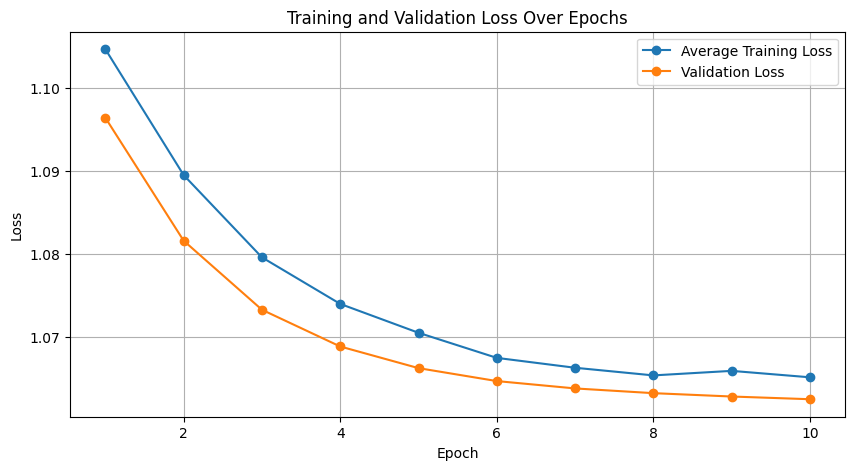

Batch Size: 64, Learning Rate: 0.0001


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 47/47 [00:02<00:00, 16.56it/s]


Epoch 1/10, Train Loss: 1.0753


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.48it/s]


Epoch 2/10, Train Loss: 1.0692


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.53it/s]


Epoch 3/10, Train Loss: 1.0683


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.53it/s]


Epoch 4/10, Train Loss: 1.0675


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.45it/s]


Epoch 5/10, Train Loss: 1.0668


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.52it/s]


Epoch 6/10, Train Loss: 1.0666


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.58it/s]


Epoch 7/10, Train Loss: 1.0663


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.55it/s]


Epoch 8/10, Train Loss: 1.0661


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.53it/s]


Epoch 9/10, Train Loss: 1.0662


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.54it/s]


Epoch 10/10, Train Loss: 1.0665
Test Set Evaluation:
Confusion Matrix:
[[   0 1972    0]
 [   0 3557    0]
 [   0 3471    0]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00      1972
   Concerned       0.40      1.00      0.57      3557
    Positive       0.00      0.00      0.00      3471

    accuracy                           0.40      9000
   macro avg       0.13      0.33      0.19      9000
weighted avg       0.16      0.40      0.22      9000

Validation Set Evaluation:
Confusion Matrix:
[[   0  648    0]
 [   0 1219    0]
 [   0 1133    0]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       648
   Concerned       0.41      1.00      0.58      1219
    Positive       0.00      0.00      0.00      1133

    accuracy                           0.41      3000
   macro avg       0.14      0.33      0.19      3000
weighted avg       0.

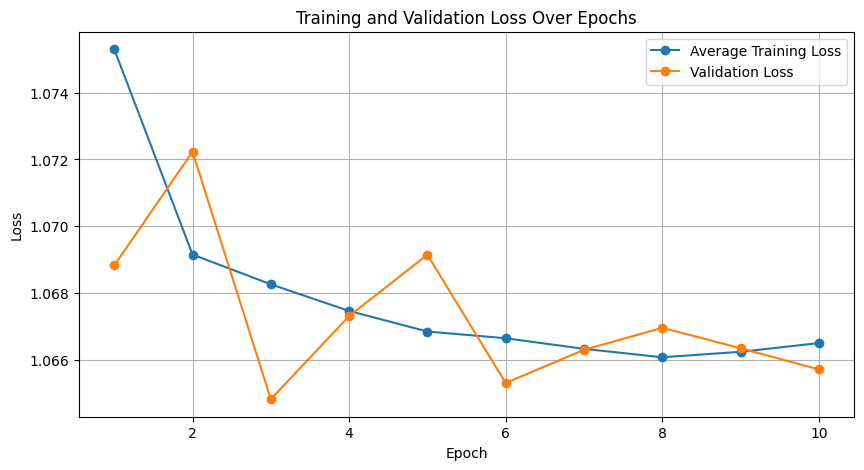

Batch Size: 64, Learning Rate: 1e-06


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 47/47 [00:02<00:00, 16.38it/s]


Epoch 1/10, Train Loss: 1.0446


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.39it/s]


Epoch 2/10, Train Loss: 0.9759


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.35it/s]


Epoch 3/10, Train Loss: 0.9277


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.35it/s]


Epoch 4/10, Train Loss: 0.9018


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.40it/s]


Epoch 5/10, Train Loss: 0.8862


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.42it/s]


Epoch 6/10, Train Loss: 0.8743


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.38it/s]


Epoch 7/10, Train Loss: 0.8666


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.37it/s]


Epoch 8/10, Train Loss: 0.8597


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.34it/s]


Epoch 9/10, Train Loss: 0.8524


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.35it/s]


Epoch 10/10, Train Loss: 0.8466
Test Set Evaluation:
Confusion Matrix:
[[ 461  737  774]
 [ 263 2455  839]
 [ 207  752 2512]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.50      0.23      0.32      1972
   Concerned       0.62      0.69      0.65      3557
    Positive       0.61      0.72      0.66      3471

    accuracy                           0.60      9000
   macro avg       0.58      0.55      0.54      9000
weighted avg       0.59      0.60      0.58      9000

Validation Set Evaluation:
Confusion Matrix:
[[160 234 254]
 [ 89 841 289]
 [ 76 242 815]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.49      0.25      0.33       648
   Concerned       0.64      0.69      0.66      1219
    Positive       0.60      0.72      0.65      1133

    accuracy                           0.61      3000
   macro avg       0.58      0.55      0.55      3000
weighted avg       0.59      0

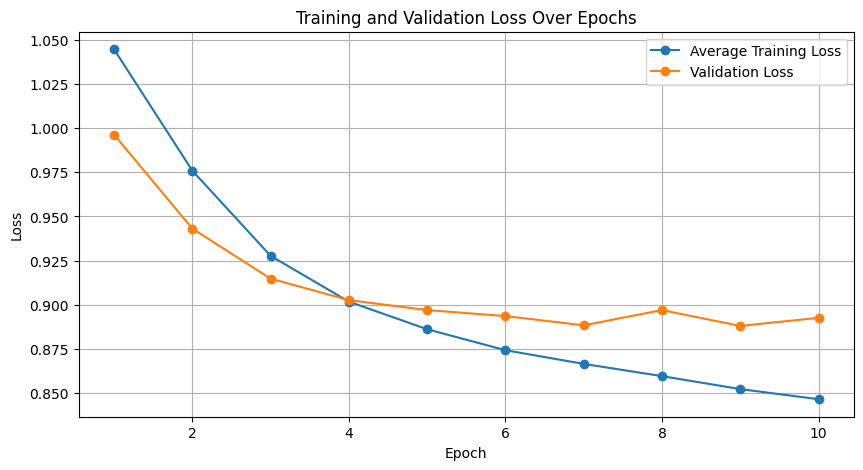

Batch Size: 64, Learning Rate: 1e-08


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 47/47 [00:02<00:00, 16.38it/s]


Epoch 1/10, Train Loss: 1.1057


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.41it/s]


Epoch 2/10, Train Loss: 1.0958


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.37it/s]


Epoch 3/10, Train Loss: 1.0892


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.39it/s]


Epoch 4/10, Train Loss: 1.0833


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.40it/s]


Epoch 5/10, Train Loss: 1.0789


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.37it/s]


Epoch 6/10, Train Loss: 1.0753


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.37it/s]


Epoch 7/10, Train Loss: 1.0732


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.38it/s]


Epoch 8/10, Train Loss: 1.0705


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.41it/s]


Epoch 9/10, Train Loss: 1.0695


Validation: 100%|██████████| 47/47 [00:02<00:00, 16.37it/s]


Epoch 10/10, Train Loss: 1.0669
Test Set Evaluation:
Confusion Matrix:
[[   0  455 1517]
 [   0  947 2610]
 [   0  622 2849]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00      1972
   Concerned       0.47      0.27      0.34      3557
    Positive       0.41      0.82      0.55      3471

    accuracy                           0.42      9000
   macro avg       0.29      0.36      0.29      9000
weighted avg       0.34      0.42      0.34      9000

Validation Set Evaluation:
Confusion Matrix:
[[  0 166 482]
 [  0 320 899]
 [  0 201 932]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       648
   Concerned       0.47      0.26      0.34      1219
    Positive       0.40      0.82      0.54      1133

    accuracy                           0.42      3000
   macro avg       0.29      0.36      0.29      3000
weighted avg       0.34      0

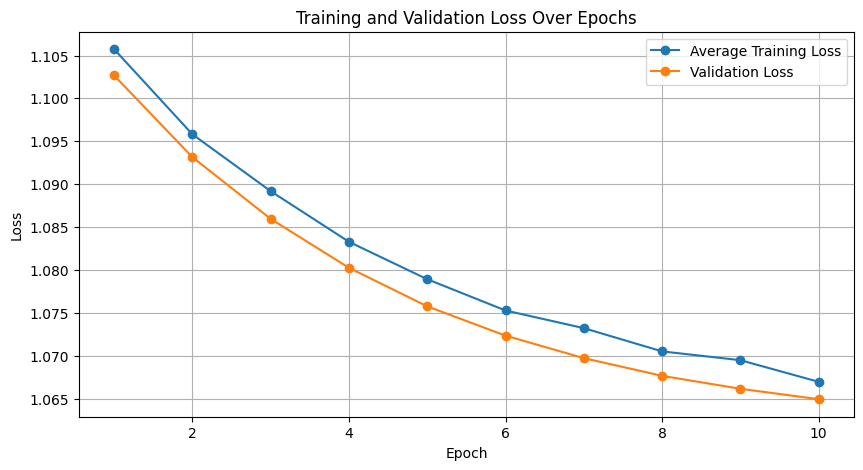

Batch Size: 128, Learning Rate: 0.0001


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 24/24 [00:02<00:00,  8.71it/s]


Epoch 1/10, Train Loss: 1.0674


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.79it/s]


Epoch 2/10, Train Loss: 1.0000


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.75it/s]


Epoch 3/10, Train Loss: 1.0682


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.72it/s]


Epoch 4/10, Train Loss: 1.0664


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.72it/s]


Epoch 5/10, Train Loss: 1.0655


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.76it/s]


Epoch 6/10, Train Loss: 1.0664


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.74it/s]


Epoch 7/10, Train Loss: 1.0657


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.73it/s]


Epoch 8/10, Train Loss: 1.0658


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.75it/s]


Epoch 9/10, Train Loss: 1.0657


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.76it/s]


Epoch 10/10, Train Loss: 1.0655
Test Set Evaluation:
Confusion Matrix:
[[   0    0 1972]
 [   0    0 3557]
 [   0    0 3471]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00      1972
   Concerned       0.00      0.00      0.00      3557
    Positive       0.39      1.00      0.56      3471

    accuracy                           0.39      9000
   macro avg       0.13      0.33      0.19      9000
weighted avg       0.15      0.39      0.21      9000

Validation Set Evaluation:
Confusion Matrix:
[[   0    0  648]
 [   0    0 1219]
 [   0    0 1133]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       648
   Concerned       0.00      0.00      0.00      1219
    Positive       0.38      1.00      0.55      1133

    accuracy                           0.38      3000
   macro avg       0.13      0.33      0.18      3000
weighted avg       0.

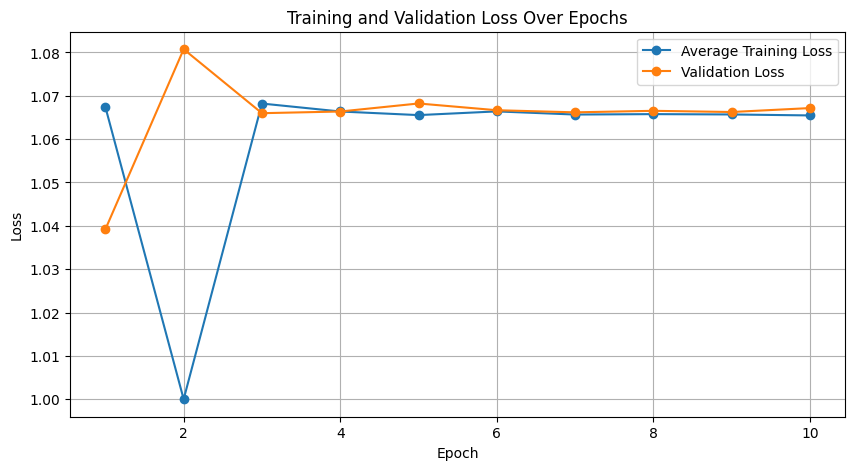

Batch Size: 128, Learning Rate: 1e-06


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 24/24 [00:02<00:00,  8.61it/s]


Epoch 1/10, Train Loss: 1.0546


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.62it/s]


Epoch 2/10, Train Loss: 1.0120


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.60it/s]


Epoch 3/10, Train Loss: 0.9736


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.60it/s]


Epoch 4/10, Train Loss: 0.9418


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.58it/s]


Epoch 5/10, Train Loss: 0.9185


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.59it/s]


Epoch 6/10, Train Loss: 0.9039


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.60it/s]


Epoch 7/10, Train Loss: 0.8934


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.60it/s]


Epoch 8/10, Train Loss: 0.8854


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.59it/s]


Epoch 9/10, Train Loss: 0.8794


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.60it/s]


Epoch 10/10, Train Loss: 0.8699
Test Set Evaluation:
Confusion Matrix:
[[ 567  657  748]
 [ 365 2326  866]
 [ 289  679 2503]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.46      0.29      0.36      1972
   Concerned       0.64      0.65      0.64      3557
    Positive       0.61      0.72      0.66      3471

    accuracy                           0.60      9000
   macro avg       0.57      0.55      0.55      9000
weighted avg       0.59      0.60      0.59      9000

Validation Set Evaluation:
Confusion Matrix:
[[191 202 255]
 [123 795 301]
 [100 223 810]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.46      0.29      0.36       648
   Concerned       0.65      0.65      0.65      1219
    Positive       0.59      0.71      0.65      1133

    accuracy                           0.60      3000
   macro avg       0.57      0.55      0.55      3000
weighted avg       0.59      0

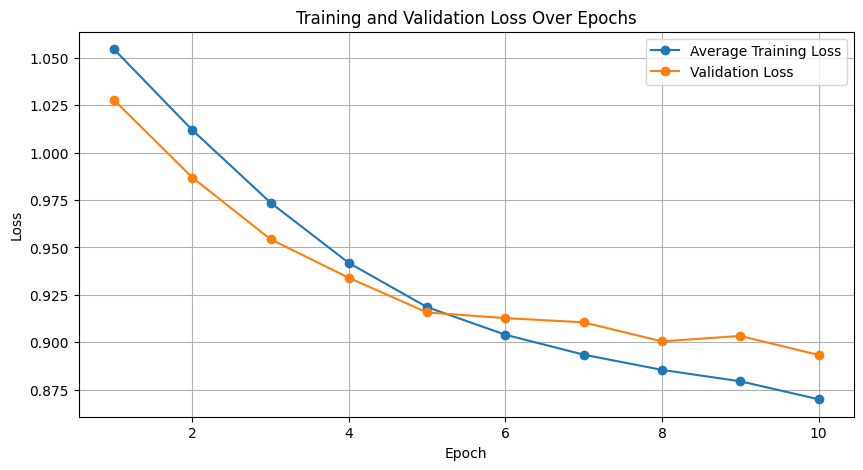

Batch Size: 128, Learning Rate: 1e-08


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 24/24 [00:02<00:00,  8.62it/s]


Epoch 1/10, Train Loss: 1.0973


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.62it/s]


Epoch 2/10, Train Loss: 1.0909


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.61it/s]


Epoch 3/10, Train Loss: 1.0875


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.59it/s]


Epoch 4/10, Train Loss: 1.0837


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.58it/s]


Epoch 5/10, Train Loss: 1.0794


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.58it/s]


Epoch 6/10, Train Loss: 1.0771


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.58it/s]


Epoch 7/10, Train Loss: 1.0753


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.60it/s]


Epoch 8/10, Train Loss: 1.0741


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.59it/s]


Epoch 9/10, Train Loss: 1.0725


Validation: 100%|██████████| 24/24 [00:02<00:00,  8.59it/s]


Epoch 10/10, Train Loss: 1.0704
Test Set Evaluation:
Confusion Matrix:
[[   0  174 1798]
 [   0  432 3125]
 [   0  247 3224]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00      1972
   Concerned       0.51      0.12      0.20      3557
    Positive       0.40      0.93      0.56      3471

    accuracy                           0.41      9000
   macro avg       0.30      0.35      0.25      9000
weighted avg       0.35      0.41      0.29      9000

Validation Set Evaluation:
Confusion Matrix:
[[   0   52  596]
 [   0  137 1082]
 [   0   72 1061]]
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       648
   Concerned       0.52      0.11      0.19      1219
    Positive       0.39      0.94      0.55      1133

    accuracy                           0.40      3000
   macro avg       0.30      0.35      0.24      3000
weighted avg       0.

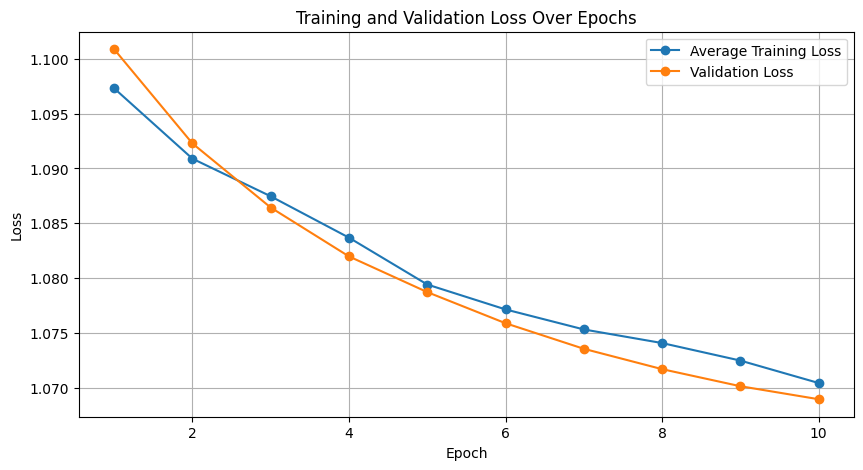

In [68]:
batch_size = [32,64,128]
LR = [1e-4, 1e-6, 1e-8]


for i in batch_size:
    for j in LR:
        print(f"Batch Size: {i}, Learning Rate: {j}")
        train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)

        model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased",
                                                           num_labels=len(labels))

        tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

        train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
        test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
        val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
        X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
        y_train = torch.tensor(train_df['category'].tolist())
        X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
        y_test = torch.tensor(test_df['category'].tolist())
        X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
        y_valid = torch.tensor(val_df['category'].tolist())

# Define a DataLoader for batching data
        train_dataset = TensorDataset(X_train, y_train)
        train_dataloader = DataLoader(train_dataset, batch_size=i, shuffle=True)
        test_dataset = TensorDataset(X_test, y_test)
        test_dataloader = DataLoader(test_dataset, batch_size=i)
        val_dataset = TensorDataset(X_valid, y_valid)
        val_dataloader = DataLoader(val_dataset, batch_size=i)

# Define the training loop
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=j)
        criterion = nn.CrossEntropyLoss()
        training_loss = []
        validation_loss = []
        for epoch in range(10):  # Run for 10 epochs
            train_loss = train(model, train_dataloader, optimizer, criterion)
            training_loss.append(train_loss)
            val_loss = validate(model, val_dataloader, criterion,device)
            validation_loss.append(val_loss)
            print(f"Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}")
# Evaluate on test and validation sets
        test_cm, test_report = evaluate(model, test_dataloader)
        print("Test Set Evaluation:")
        print("Confusion Matrix:")
        print(test_cm)
        print("Classification Report:")
        print(test_report)

        valid_cm, valid_report = evaluate(model, val_dataloader)
        print("Validation Set Evaluation:")
        print("Confusion Matrix:")
        print(valid_cm)
        print("Classification Report:")
        print(valid_report)
        plot_loss_over_epochs(training_loss, validation_loss)